# GNN-based Antenna Array Clustering

This notebook demonstrates Graph Neural Networks for clustering irregular antenna arrays
using unsupervised learning with MinCut optimization.

**Architecture overview:**
1. Graph Construction: Convert antenna positions to k-NN graph
2. GNN Layers: GAT/GCN for learning node embeddings
3. Clustering Head: Soft assignment via softmax
4. Loss: MinCut + Orthogonality (no labels needed)

## 1. Imports and Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

# Import GNN modules
from gnn import (
    GNNConfig,
    GraphConfig,
    TrainingConfig,
    Trainer,
    train_clustering,
    cluster_sizes,
    compute_clustering_metrics,
    set_seed
)

# Set seed for reproducibility
set_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA available: False


## 2. Generate Sample Antenna Array

Create an irregular 16x16 antenna array with random perturbations.

In [2]:
def generate_irregular_array(grid_size=16, perturbation=0.3, seed=42):
    """
    Generate an irregular antenna array.
    
    Args:
        grid_size: Number of elements per dimension
        perturbation: Standard deviation of position noise
        seed: Random seed
        
    Returns:
        positions: (N, 2) array of antenna positions
    """
    np.random.seed(seed)
    
    # Create base grid
    x = np.linspace(0, grid_size - 1, grid_size)
    y = np.linspace(0, grid_size - 1, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    # Flatten to (N, 2)
    positions = np.stack([xx.flatten(), yy.flatten()], axis=1).astype(np.float32)
    
    # Add random perturbations
    noise = np.random.randn(positions.shape[0], 2) * perturbation
    positions += noise.astype(np.float32)
    
    return positions


# Generate 16x16 irregular array
positions = generate_irregular_array(grid_size=16, perturbation=0.3)
print(f"Generated {positions.shape[0]} antenna elements")
print(f"Position range: x=[{positions[:, 0].min():.2f}, {positions[:, 0].max():.2f}], "
      f"y=[{positions[:, 1].min():.2f}, {positions[:, 1].max():.2f}]")

Generated 256 antenna elements
Position range: x=[-0.29, 15.92], y=[-0.57, 15.57]


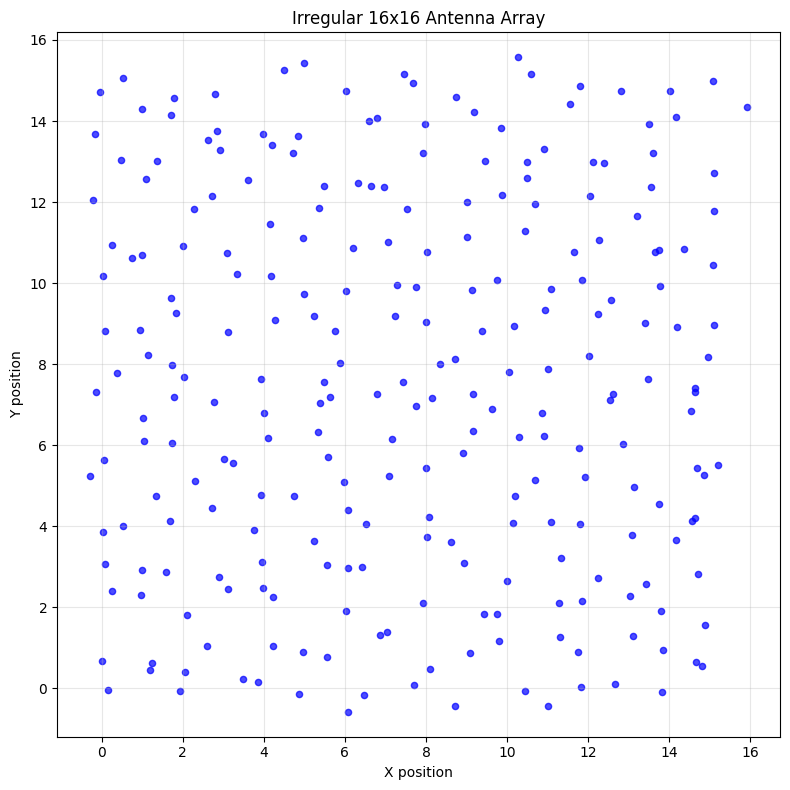

In [3]:
# Visualize the antenna array
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], c='blue', s=20, alpha=0.7)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Irregular 16x16 Antenna Array')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Configure and Train GNN Clustering

Set up the GNN configuration and train the model.

In [4]:
# Configuration
num_clusters = 4  # K = 4 clusters

gnn_config = GNNConfig(
    in_dim=2,           # x, y positions
    hidden_dim=64,      # Hidden layer dimension
    num_clusters=num_clusters,
    num_layers=3,       # 3 GAT layers
    heads=4,            # 4 attention heads
    dropout=0.1,
    layer_type="gat"    # Use GAT (recommended)
)

graph_config = GraphConfig(
    k_neighbors=8,      # k-NN with k=8
    connection_type="knn",
    add_self_loops=True
)

training_config = TrainingConfig(
    epochs=500,
    lr=1e-3,
    weight_decay=5e-4,
    lambda_ortho=1.0,   # Orthogonality loss weight
    lambda_entropy=0.0, # Entropy regularization (optional)
    verbose=50          # Print every 50 epochs
)

print("GNN Configuration:")
print(f"  - Layers: {gnn_config.num_layers} x {gnn_config.layer_type.upper()}")
print(f"  - Hidden dim: {gnn_config.hidden_dim}")
print(f"  - Attention heads: {gnn_config.heads}")
print(f"  - Output clusters: {gnn_config.num_clusters}")
print(f"\nGraph Configuration:")
print(f"  - k-NN neighbors: {graph_config.k_neighbors}")
print(f"\nTraining Configuration:")
print(f"  - Epochs: {training_config.epochs}")
print(f"  - Learning rate: {training_config.lr}")

GNN Configuration:
  - Layers: 3 x GAT
  - Hidden dim: 64
  - Attention heads: 4
  - Output clusters: 4

Graph Configuration:
  - k-NN neighbors: 8

Training Configuration:
  - Epochs: 500
  - Learning rate: 0.001


In [ ]:
# Create trainer and fit
trainer = Trainer(
    num_clusters=num_clusters,
    gnn_config=gnn_config,
    graph_config=graph_config,
    training_config=training_config
)

print("Training GNN...\n")
result = trainer.fit(positions)

print(f"\nTraining complete!")
print(f"Final loss: {result.final_loss:.4f}")

Training GNN...

Epoch 50/500: Loss = -0.9569
Epoch 100/500: Loss = -0.9589


## 4. Analyze Results

In [ ]:
# Get cluster assignments
clusters = result.cluster_assignments
sizes = cluster_sizes(clusters)

print("Cluster Distribution:")
for k, size in enumerate(sizes):
    print(f"  Cluster {k}: {size} elements ({100*size/len(clusters):.1f}%)")

In [ ]:
# Plot training loss curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(result.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(len(sizes)), sizes, color=['C0', 'C1', 'C2', 'C3'][:len(sizes)])
plt.xlabel('Cluster')
plt.ylabel('Number of Elements')
plt.title('Cluster Sizes')
plt.xticks(range(len(sizes)))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize clustering result
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

plt.figure(figsize=(10, 10))

for k in range(num_clusters):
    mask = clusters == k
    plt.scatter(
        positions[mask, 0], 
        positions[mask, 1],
        c=colors[k % len(colors)],
        s=50,
        label=f'Cluster {k} ({sizes[k]} elements)',
        alpha=0.7
    )

plt.xlabel('X position')
plt.ylabel('Y position')
plt.title(f'GNN Clustering Result (K={num_clusters})')
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Quick Clustering with Convenience Function

For simple use cases, use `train_clustering()` directly.

In [ ]:
# Quick clustering example
clusters_quick = train_clustering(
    positions,
    num_clusters=4,
    k_neighbors=8,
    epochs=300,
    lr=1e-3,
    verbose=100
)

print(f"\nCluster distribution: {np.bincount(clusters_quick)}")

## 6. Compute Clustering Metrics

In [ ]:
# Compute clustering quality metrics
metrics = compute_clustering_metrics(clusters, positions)

print("Clustering Metrics:")
print(f"  - Number of clusters: {metrics['num_clusters']}")
print(f"  - Cluster sizes: {metrics['cluster_sizes']}")
print(f"  - Size variance: {metrics['size_variance']:.2f}")
print(f"  - Mean intra-cluster distance: {metrics['mean_intra_distance']:.2f}")

## 7. Soft Assignments Visualization

The GNN outputs soft cluster probabilities. Let's visualize the confidence of assignments.

In [ ]:
# Get soft assignments
soft = result.soft_assignments

# Compute confidence (max probability)
confidence = soft.max(axis=1)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    positions[:, 0], 
    positions[:, 1],
    c=confidence,
    cmap='RdYlGn',
    s=50,
    vmin=0.5,
    vmax=1.0
)
plt.colorbar(scatter, label='Assignment Confidence')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Cluster Assignment Confidence')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean confidence: {confidence.mean():.3f}")
print(f"Min confidence: {confidence.min():.3f}")
print(f"Elements with >90% confidence: {(confidence > 0.9).sum()} / {len(confidence)}")